In [8]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
from getdist import plots, MCSamples, loadMCSamples
import getdist
from IPython.display import display, clear_output

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=False
fsize=14

def create_pivot_redshifts(N, start, stop):
    pivots = np.linspace(start=start, stop=stop, num=N+2)
    free_pivots = pivots[1:-1]

    str_pivots = ["{:.4f}".format(p) for p in pivots]
    str_pivots = ",".join(str_pivots)

    return [pivots, free_pivots, str_pivots]

def param_pairs(params_to_plot):
    n=len(params_to_plot)
    param_combos = []

    for i in np.arange(n):
        for j in np.arange(n):
            if i>j:
                param_combos.append([params_to_plot[i], params_to_plot[j]])
    return param_combos

In [9]:
######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing
######################################################

planck_baseline_sigma = {
    "omega_b": 0.00015,
    "omega_cdm": 0.0012,
    "n_s": 0.0042,
    "tau_reio": 0.0073,
    "ln10^{10}A_s": 0.014,
    "H0": 0.54
}

######################################################
# Noise settings
######################################################

noise_parameters = {'beam_FWHM_143_arcmin' : 7.22,
                        'beam_FWHM_217_arcmin' : 4.90,
                        'weight_inv_T_143' : 0.36e-4,
                        'weight_inv_P_143' : 1.61e-4,
                        'weight_inv_T_217' : 0.78e-4,
                        'weight_inv_P_217' : 3.25e-4,
                        'fsky' : 0.68,
                        'use_143' : True,
                        'use_217' : True
                        }  

priors = {'tau_reio': 0.0073}

######################################################
# Perturbation settings
######################################################

Npivots = 7
zmin_pert = 800
zmax_pert = 1400
pivot_info = create_pivot_redshifts(Npivots, zmin_pert, zmax_pert)

In [10]:
######################################################
# Load Planck chains
######################################################
planck_path = "/Users/gabe/projects/planck/chains/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE"

s = loadMCSamples(planck_path)
bestfit_dict = s.getParamBestFitDict()
planck_baseline_params = {
    "omega_b": bestfit_dict["omegabh2"],
    "omega_cdm": bestfit_dict["omegach2"],
    "n_s": bestfit_dict["ns"],
    "tau_reio": bestfit_dict["tau"],
    "ln10^{10}A_s": bestfit_dict["logA"],
    #"100*theta_s": bestfit_dict["theta_s_1e2"]
    "H0": bestfit_dict["H0"]
}

In [11]:
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
from RecTools import *

steps = {
    "omega_b": 0.00015,
    "omega_cdm": 0.0012,
    "n_s": 0.1*0.0042,
    "tau_reio": 0.0073,
    "ln10^{10}A_s": 0.1*0.014,
    #"1e9*A_s*exp(-2tau)": 0.011, 
    "H0": 0.54
}

recombination_params = {"zmax_pert": zmax_pert,
                        "zmin_pert": zmin_pert,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'none',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 15,
                        #"ll_min_tt": 10,
                        "priors": priors,
                        }

recombination_params["delta_param"] = steps
calc = FisherCalculator(planck_baseline_params, recombination_params, "test")
target_params = [*planck_baseline_params.keys()]
fm = calc.compute_Fisher(target_params)

Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
Fisher matrices calculation completed at 05/25/2023, 17:23:52


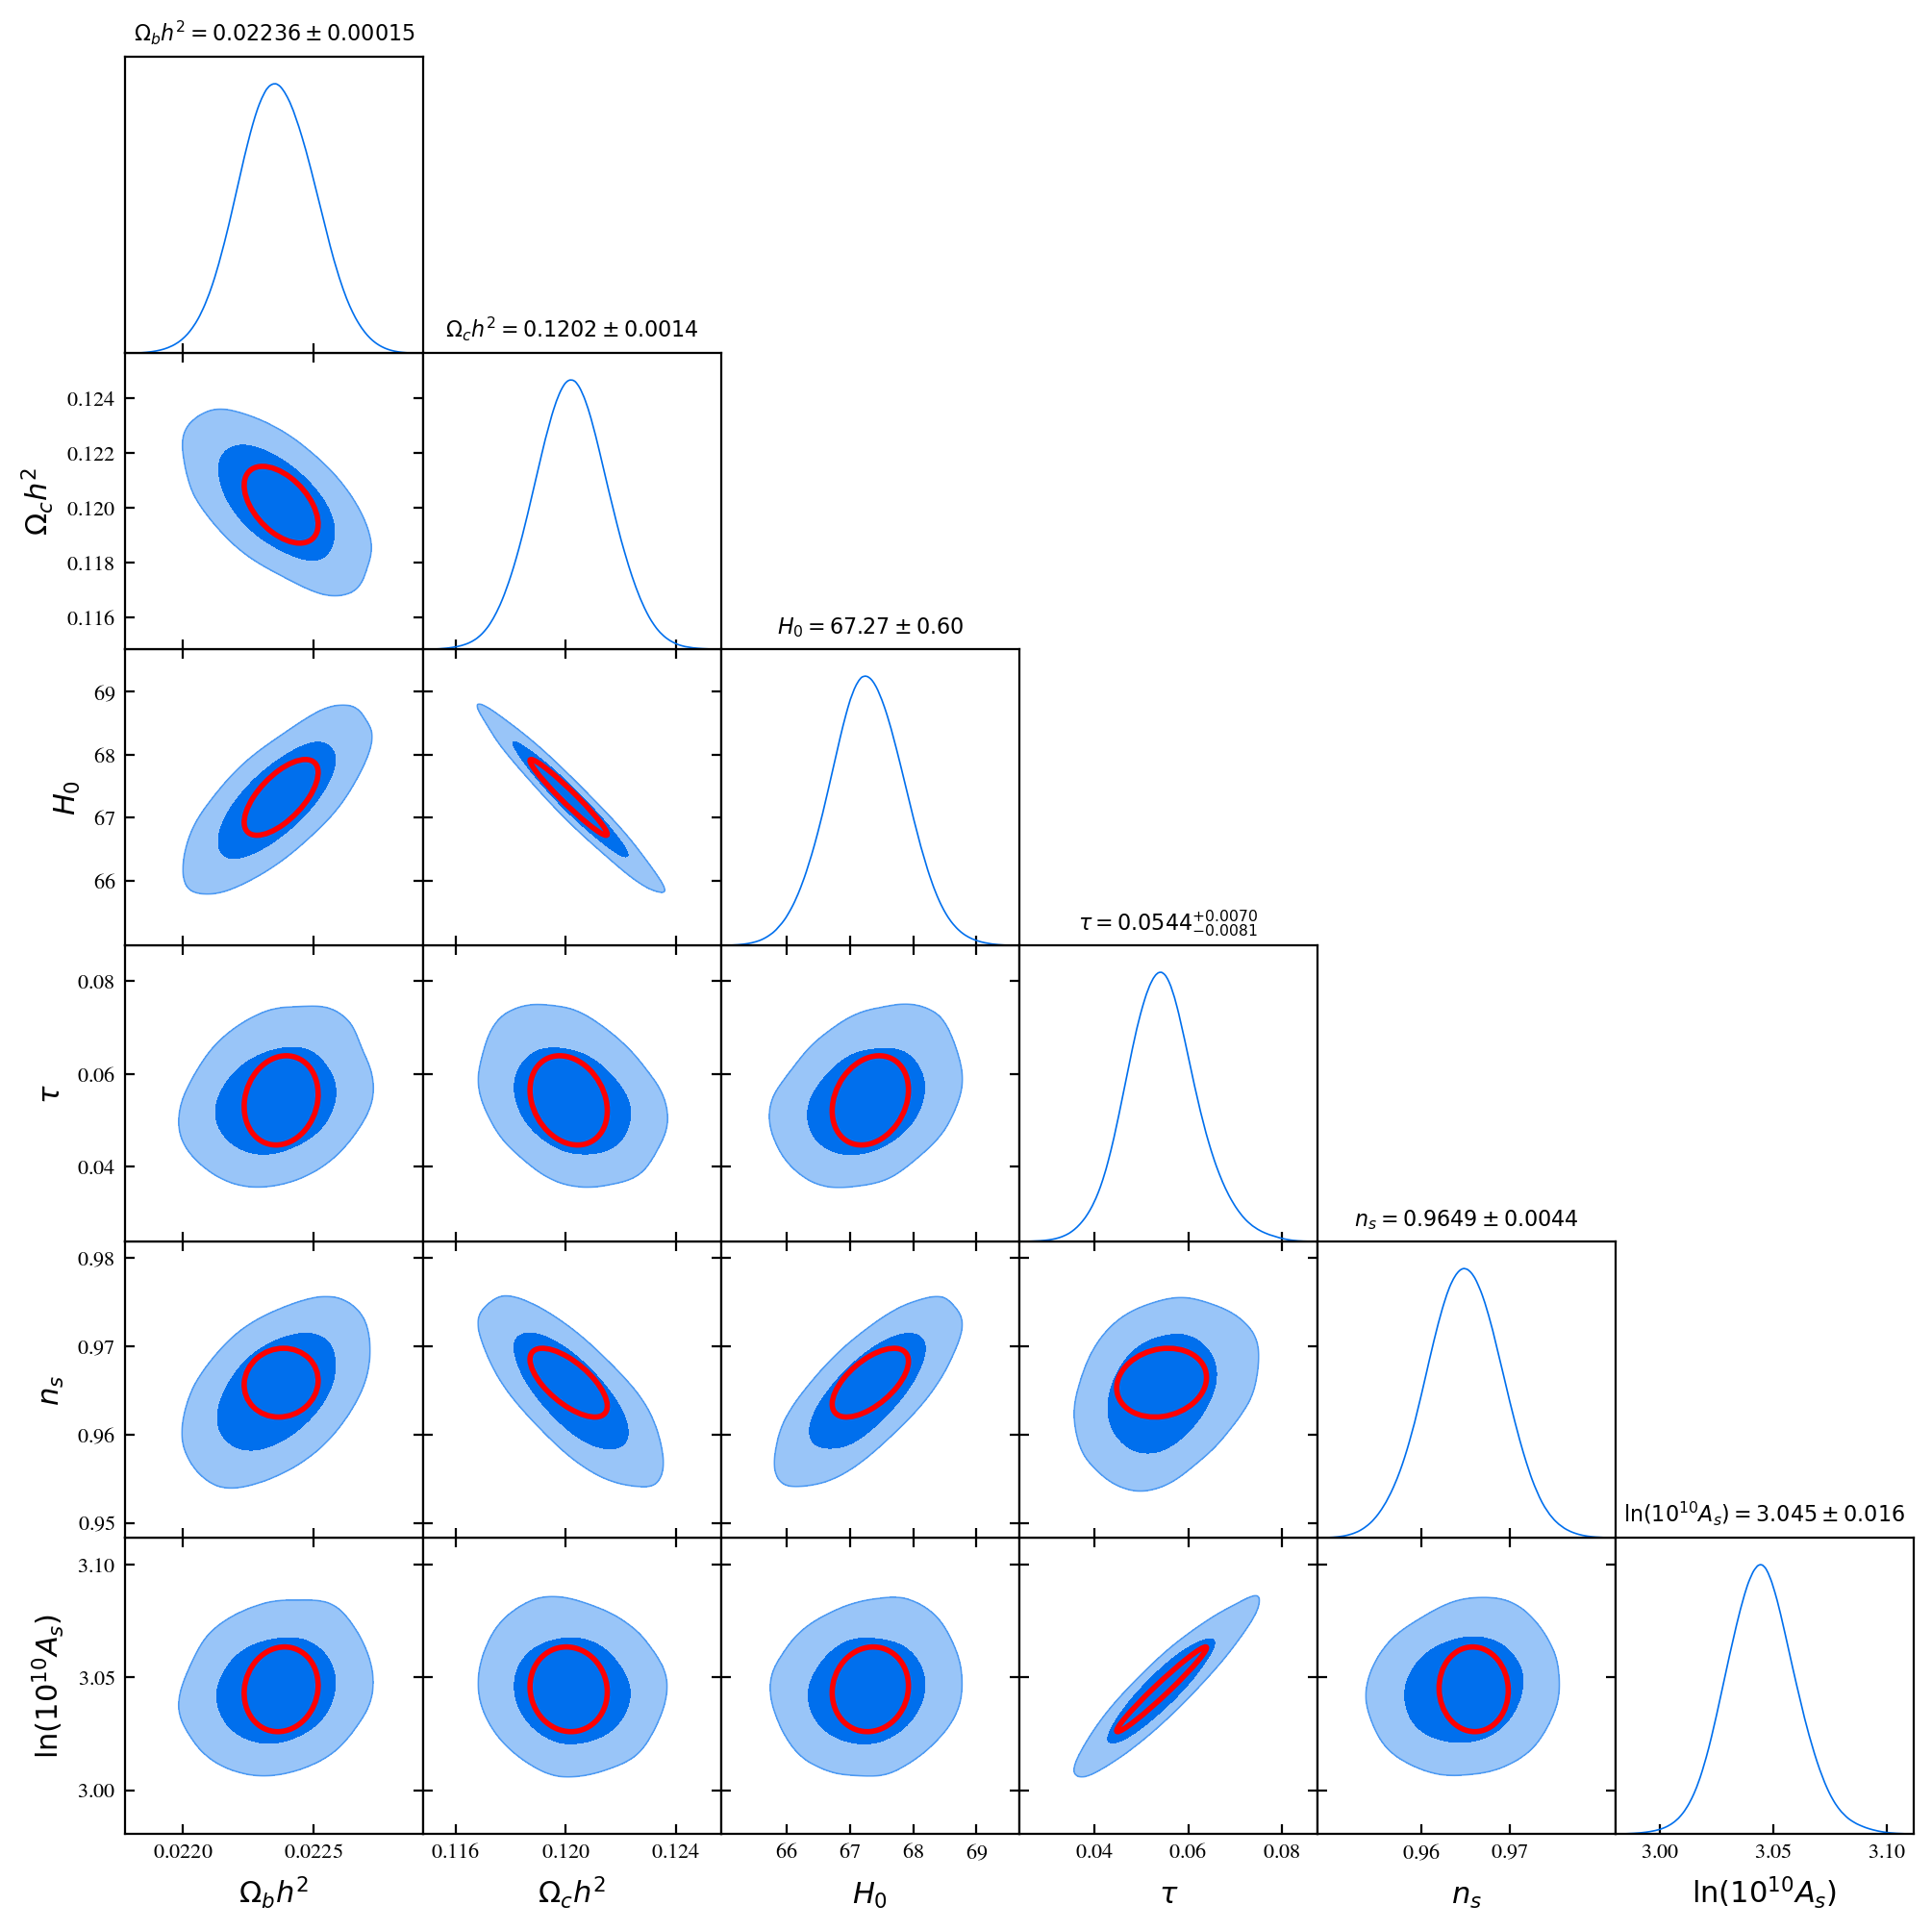

In [12]:
g = plots.get_subplot_plotter()
params_to_plot = ['omegabh2', 'omegach2', 'H0', 'tau', 'ns', 'logA']
param_combos = param_pairs(params_to_plot)
g.triangle_plot([s], params_to_plot, filled=True, title_limit=1)
for c in param_combos:
    names = c.copy()
    ax=g.get_axes((c[1], c[0]))
    if(c[0]=="logA"):
        names[0]="ln10^{10}A_s"
    if(c[1]=="logA"):
        names[1]="ln10^{10}A_s"
    if(c[0]=="theta_s_1e2"):
        names[0]="100*theta_s"
    if(c[1]=="theta_s_1e2"):
        names[1]="100*theta_s"
    if(c[0]=="omegabh2"):
        names[0]="omega_b"
    if(c[1]=="omegabh2"):
        names[1]="omega_b"
    if(c[0]=="omegach2"):
        names[0]="omega_cdm"
    if(c[1]=="omegach2"):
        names[1]="omega_cdm"
    if(c[0]=="ns"):
        names[0]="n_s"
    if(c[1]=="ns"):
        names[1]="n_s"
    if(c[0]=="tau"):
        names[0]="tau_reio"
    if(c[1]=="tau"):
        names[1]="tau_reio"
    ax.add_patch(fm.ellipse2d([names[1], names[0]]))

#g.export("../results/planck_triangle_with_fisher.png")

In [13]:
for p in planck_baseline_params.keys():
    print("{}: {}".format(p, np.sqrt(1./fm.get_marginalized_1d(p))))

omega_b: 9.40373949052944e-05
omega_cdm: 0.0009276892728782449
n_s: 0.002581634747356256
tau_reio: 0.006377500805074816
ln10^{10}A_s: 0.012440735755818876
H0: 0.3990817594954272


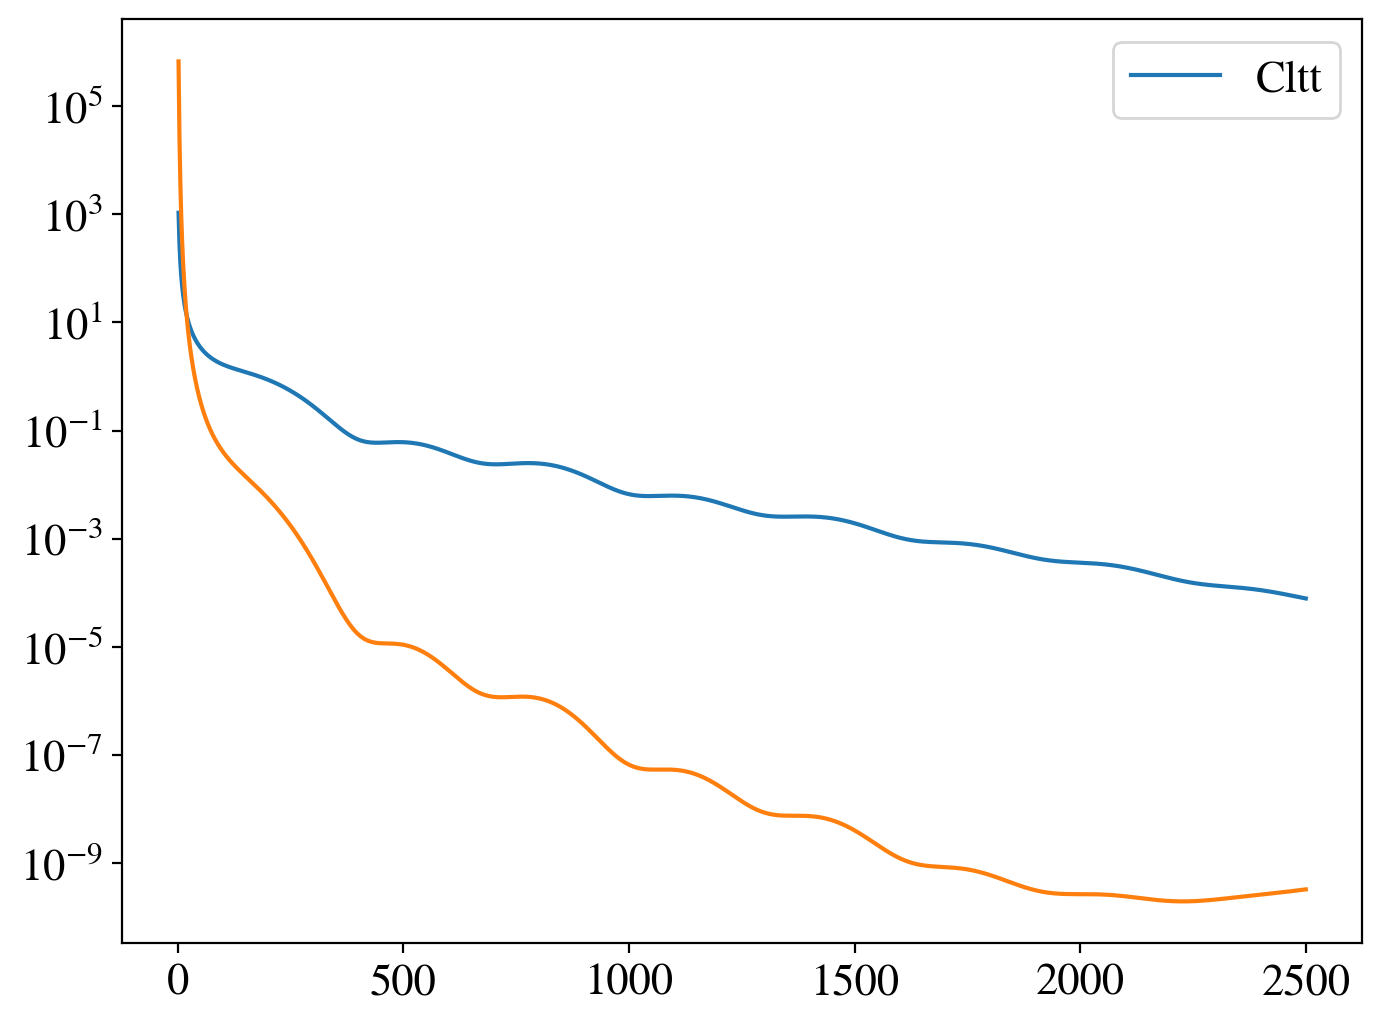

In [18]:
fig,ax = plt.subplots()
ll = np.arange(2, 2501)
dl_factor = ll*(ll+1)/(2*np.pi)

ax.plot(ll, calc.tt_fid, label="Cltt")
ax.plot(ll, calc.error_covariance[:,0,0])
ax.set_yscale("log")
ax.legend()
plt.show()

In [ ]:
label_dict = {
    "omega_b": "\omega_b",
    "omega_cdm": "\omega_{cdm}",
    "n_s": "n_s",
    "tau_reio": "\\tau_{reio}",
    "ln10^{10}A_s": "\ln10^{10} A_s",
    "H0": "H_0"
}

def plot_fisher(fm, label_dict, tight_layout=False, padding=5):
    params_to_plot = fm.col_names
    param_combos = param_pairs(params_to_plot)
#params_to_plot = ["omega_b", "omega_cdm", "H0", "tau_reio", "n_s", "ln10^{10}A_s"]
    n = len(params_to_plot)
    fig,axes = plt.subplots(n, n, figsize=(10,10), sharex='col', sharey='row')
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for i in range(n):
        for j in range(n):
            if(i<=j):
                axes[i,j].axis('off')
                continue
    param_combos = param_pairs(params_to_plot)
    for c in param_combos:
        names = c.copy()
        i = params_to_plot.index(names[0])
        j = params_to_plot.index(names[1])
        sigmax = np.sqrt(1/fm.get_marginalized_1d(names[1]))
        sigmay = np.sqrt(1/fm.get_marginalized_1d(names[0]))
        axes[i,j].set_xlim([fm.varied_params[names[1]]-padding*sigmax, fm.varied_params[names[1]]+padding*sigmax])
        axes[i,j].set_ylim([fm.varied_params[names[0]]-padding*sigmay, fm.varied_params[names[0]]+padding*sigmay])
        axes[i,j].add_patch(fm.ellipse2d([names[1], names[0]]))
    for i in range(n):
        axes[n-1-i,0].set_ylabel("${}$".format(label_dict[params_to_plot[n-1-i]], fontsize=8))
        axes[n-1-i,0].locator_params(axis='y', nbins=1)
        axes[n-1-i,0].tick_params(axis='y', labelsize=8)
        axes[-1, i].set_xlabel("${}$".format(label_dict[params_to_plot[i]], fontsize=8))
        axes[-1,i].locator_params(axis="x", nbins=1)
        axes[-1,i].tick_params(axis="x", labelsize=8)

    return fig,axes


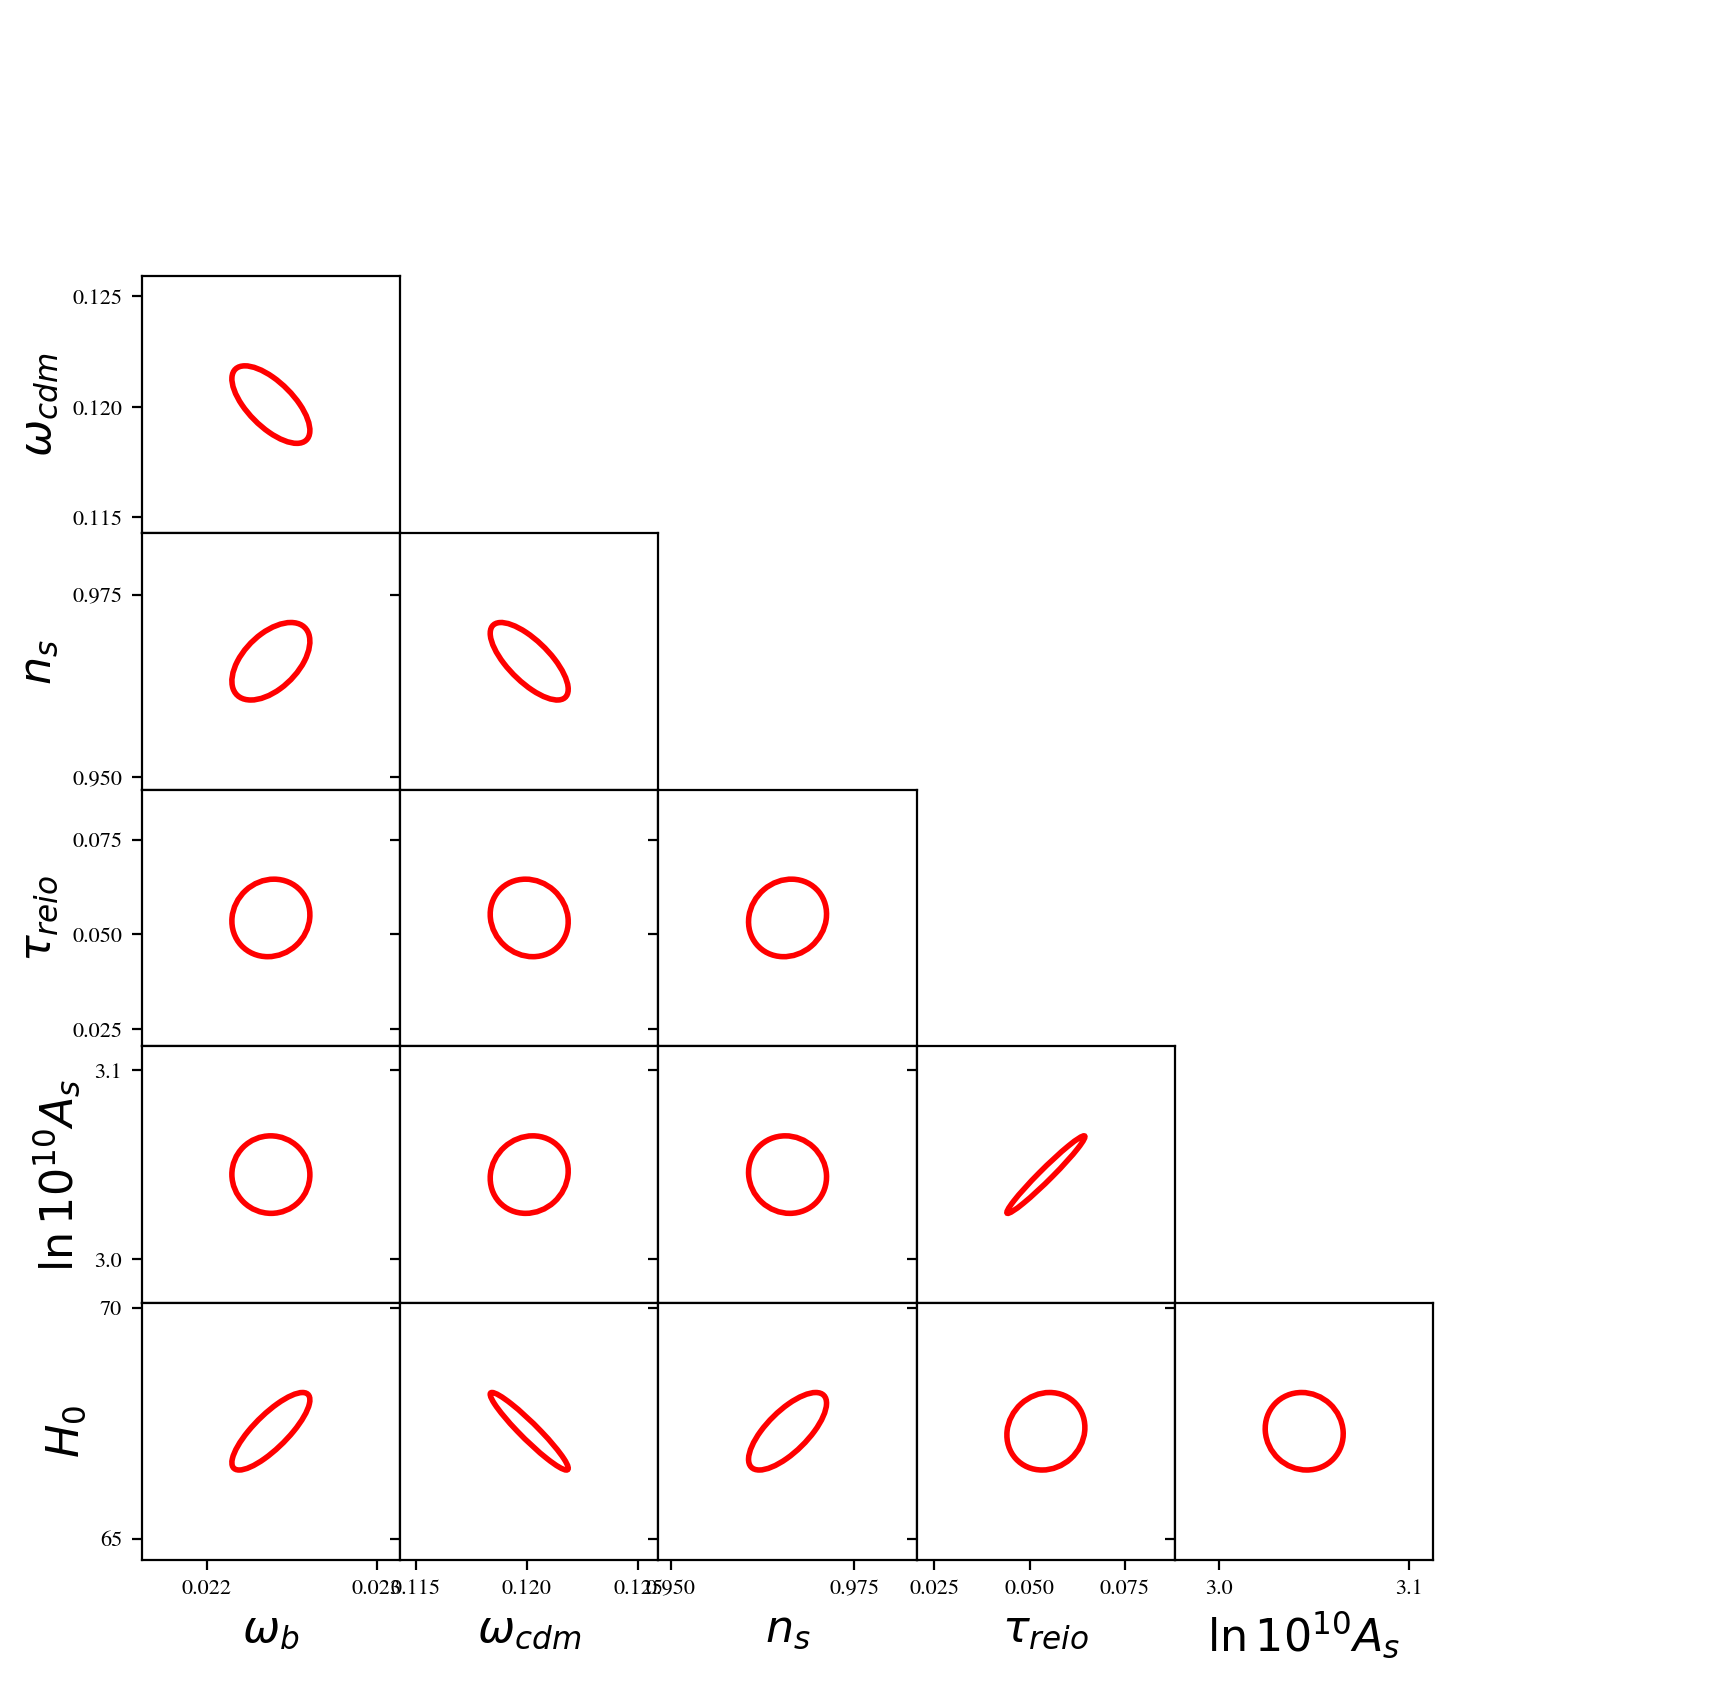

In [ ]:
fig, ax = plot_fisher(fm, label_dict=label_dict)
plt.show()

In [ ]:
def decorrelate(F):
    u, s, vh = np.linalg.svd(F.Fisher)
    decorr_fisher = FisherMatrix()
    decorr_fisher.Fisher = np.diag(s)
    decorr_fisher.col_names = ["theta_{}".format(i) for i in range(len(F.col_names))]
    decorr_fisher.class_parameters = F.class_parameters
    decorr_fisher.fisher_settings = F.fisher_settings
    ## the following line rotates the fiducial point to the corresponding point in the new input variables
    transformed = np.einsum("ij,j->i", vh, list(F.varied_params.values()) )
    decorr_fisher.varied_params = {k:transformed[i] for i,k in enumerate(decorr_fisher.col_names)}
    return decorr_fisher


{'theta_0': 0.05165876164133411, 'theta_1': 0.2498819241699517, 'theta_2': -1.508011575474679, 'theta_3': -0.4186737327715019, 'theta_4': -2.817434821838008, 'theta_5': 67.32006243142294}


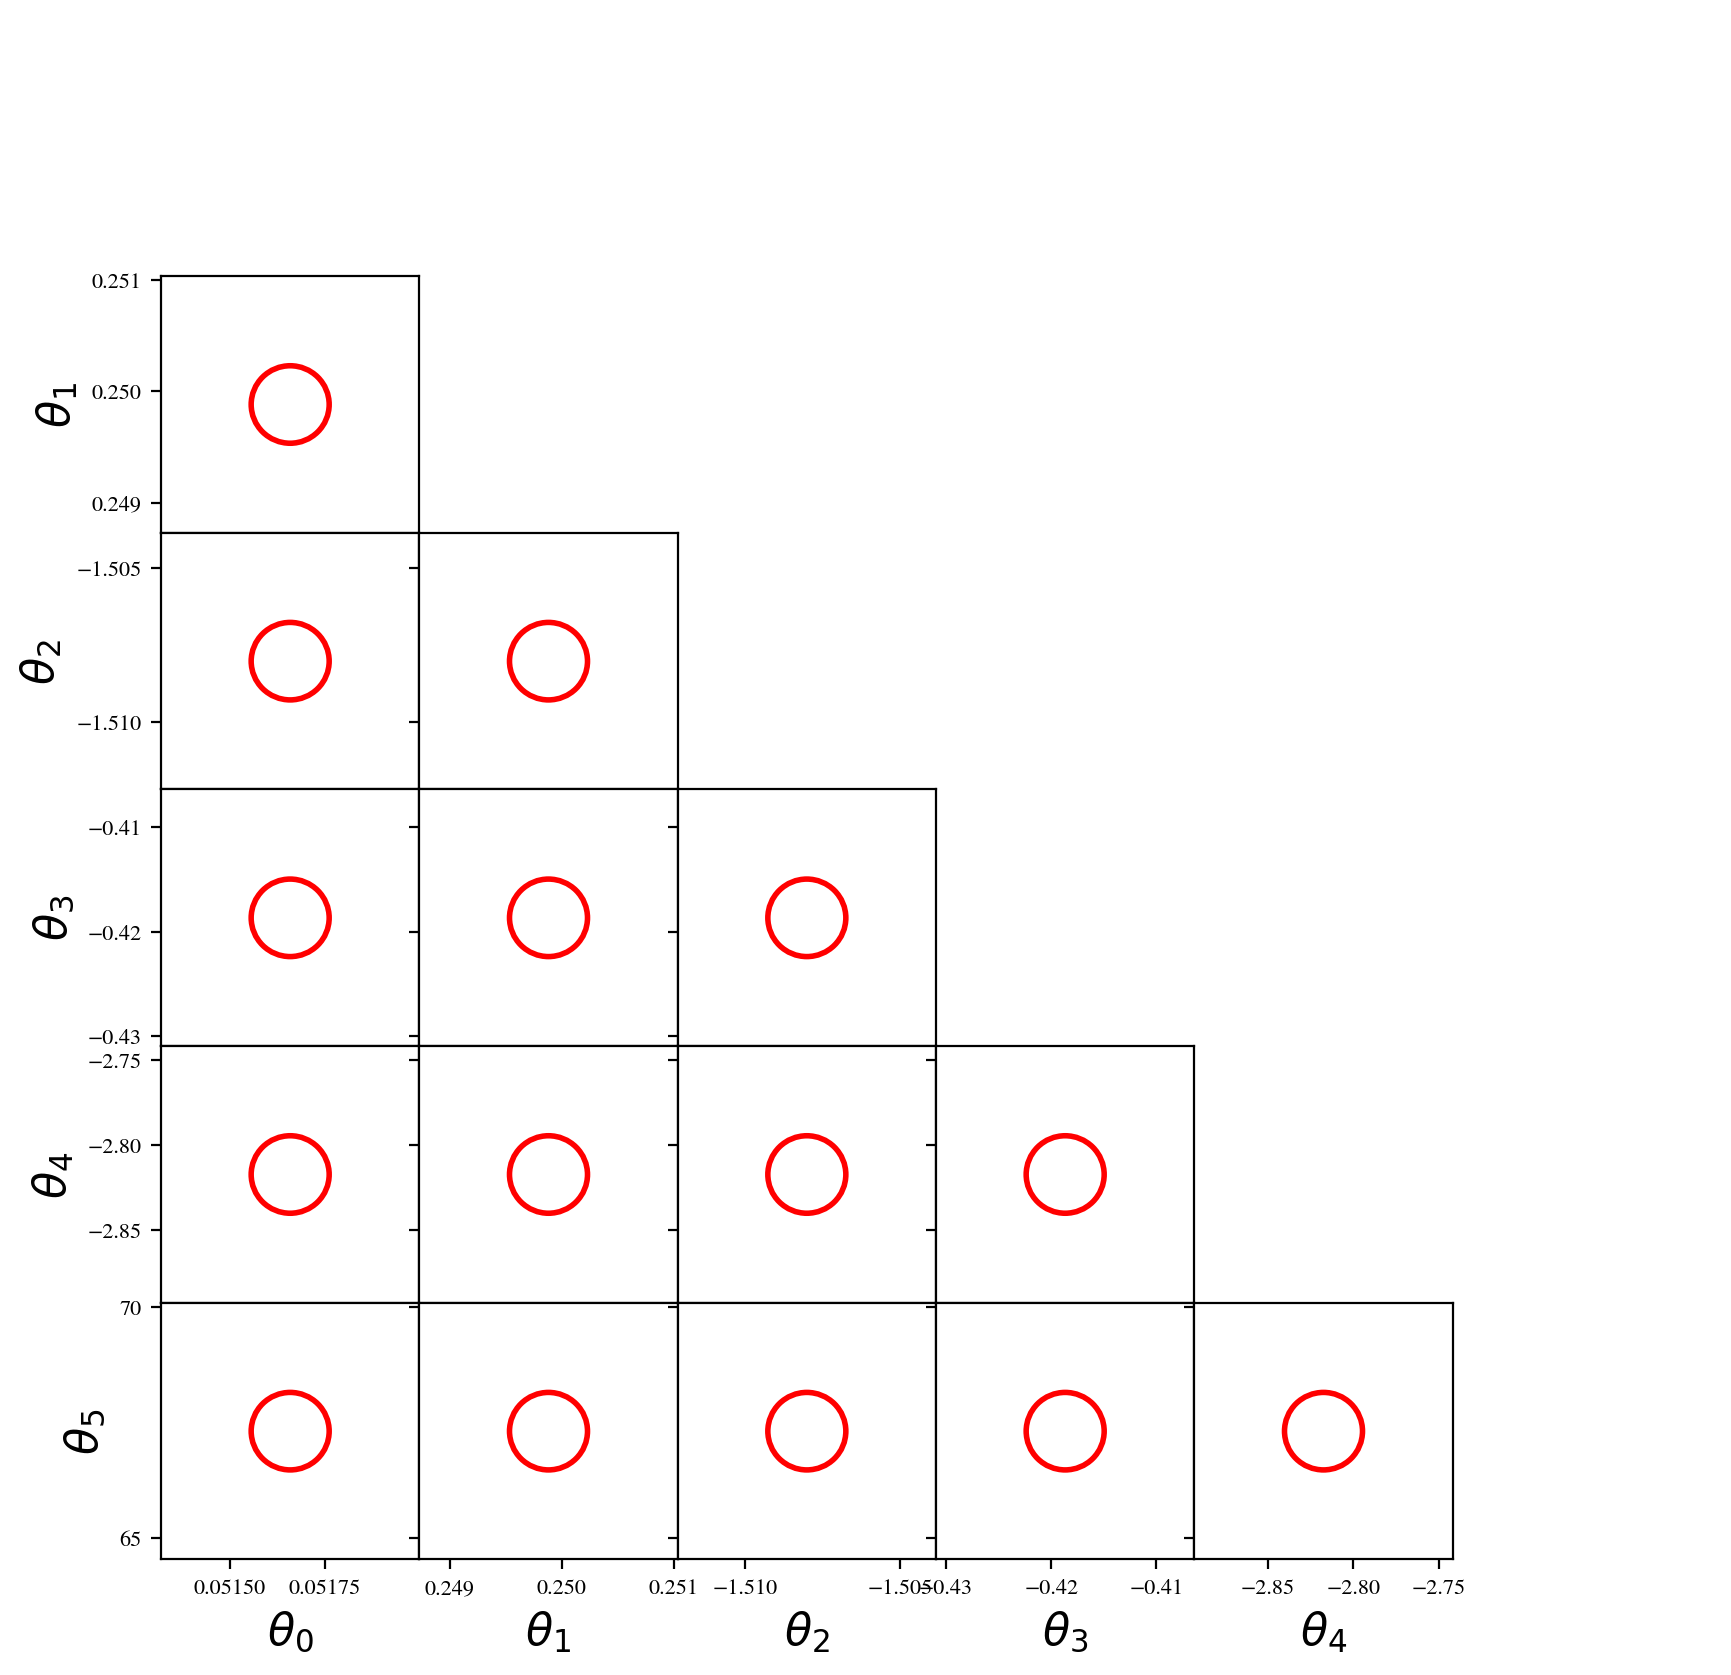

In [ ]:
decorr_fm = decorrelate(fm)
print(decorr_fm.varied_params)
fig, ax = plot_fisher(decorr_fm, label_dict={k:"\\{}".format(k) for k in decorr_fm.col_names})
plt.show()

In [ ]:
from scipy.stats import qmc
from scipy.special import gamma

#radius in units of sigma
def fisher_hypersphere_sampling(F, N, radius=4):
    d = len(F.col_names)
    ## SVD of the input Fisher 
    u,s,vh = np.linalg.svd(F.Fisher)
    ## Decorrelated fisher object (contains info about fiducial point)
    decorr = decorrelate(F)
    ranges = {}
    j=0
    for param,value in decorr.varied_params.items():
        sig = np.sqrt(1./s[j])
        ## LHC expands 4 sigma around the fiducial point
        ranges[param] = [value-radius*sig, value+radius*sig]
        j+=1

    ## Scales up the number of points from N to x based on the ratio of 
    ## the volume of a hypersphere to hypercube in d dimensional space
    ## will ensure roughly N points in final hypersphere
    x = int(N*d*2**(d-1)*gamma(d/2.)/(np.pi**(d/2.)))
    sampler = qmc.LatinHypercube(d=d)
    samples = sampler.random(n=x)
    i=0
    for range in ranges.values():
        samples.T[i] *= range[1] - range[0]
        samples.T[i] += range[0]
        i+=1
    ind_to_keep = []
    for i, sa in enumerate(samples):
        ## checks if the distance between a point in the sampled points and the fiducial points
        ## measured where the unit on each axis is the uncertainty along that direction 
        ## is less than 4 (4 sigma), and keeps if it is.
        if np.linalg.norm(np.divide(sa-list(decorr.varied_params.values()), np.sqrt(1/s)))<radius:
            ind_to_keep.append(i)

    samples = samples[ind_to_keep]
    print("{} points within hypersphere".format(len(samples)))
    final = np.einsum("ij,kj->ki", u, samples)
    final = np.vstack(final)
    return final

N=50000
samps = fisher_hypersphere_sampling(fm, N, 10)

49993 points within hypersphere


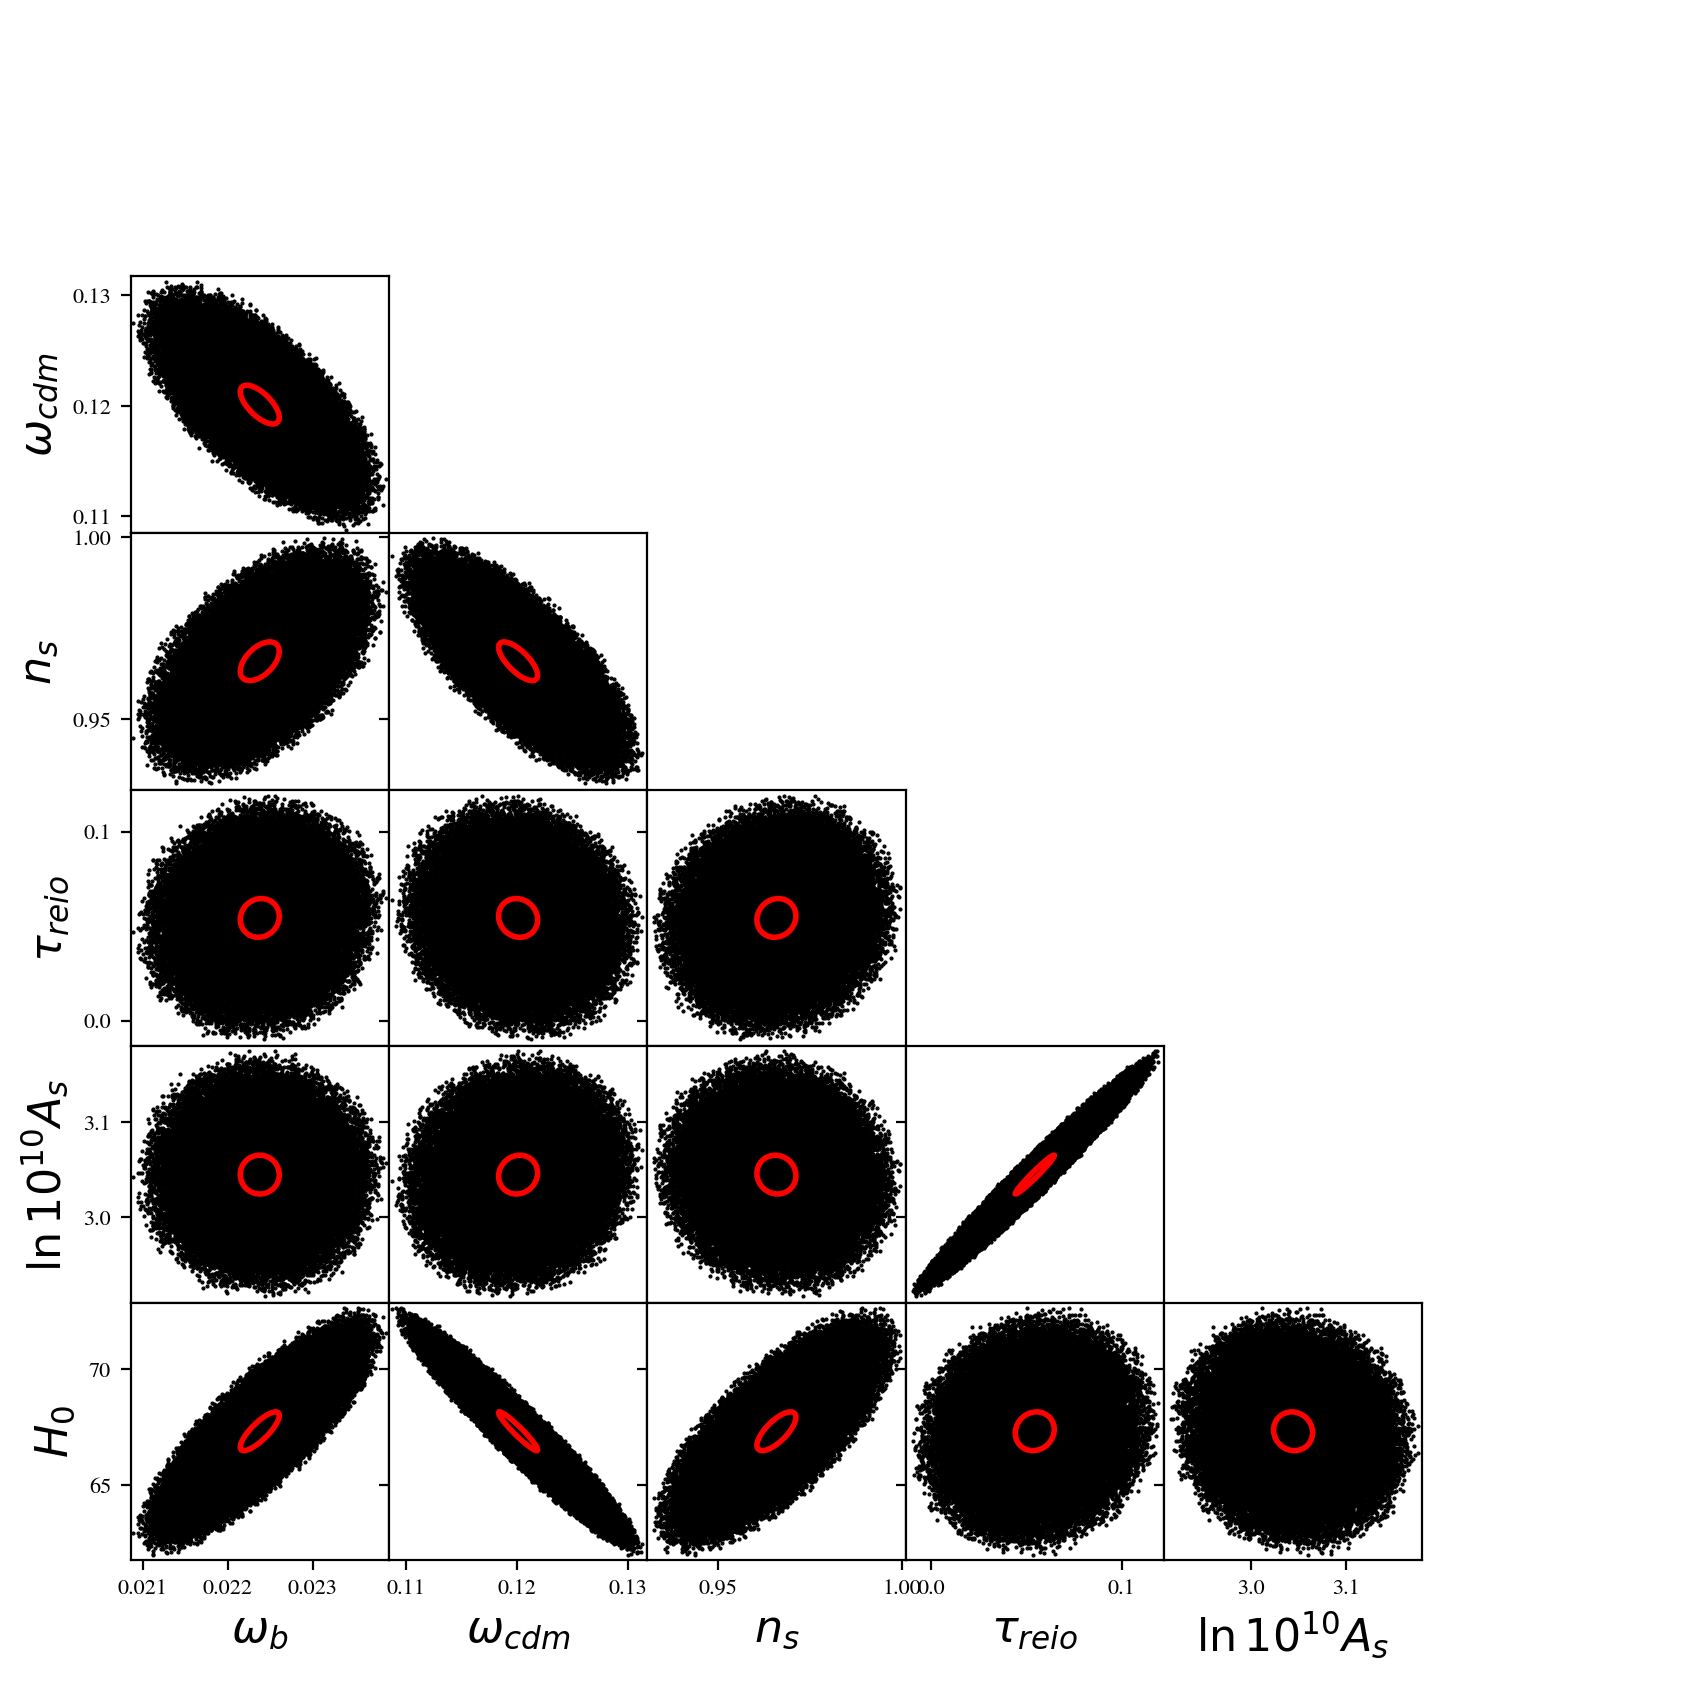

In [ ]:
def plot_points(ax, points):
    n = points.shape[1]
    for i in range(n):
        for j in range(n):
            if(i<=j):
                continue
            ax[i,j].scatter(points[:,j], points[:,i], marker='.', s=1, color='black')

decorr_fm = decorrelate(fm)
fig, ax = plot_fisher(fm, label_dict=label_dict, padding=10)
plot_points(ax, samps)
#plt.savefig("../results/FHS_example.pdf",dpi=300, bbox_inches='tight')
plt.show()

# With control points

In [ ]:
######################################################
# Noise settings
######################################################

noise_parameters = {'beam_FWHM_143_arcmin' : 7.3,
                        'beam_FWHM_217_arcmin' : 4.90,
                        'weight_inv_T_143' : 0.36e-4,
                        'weight_inv_P_143' : 1.61e-4,
                        'weight_inv_T_217' : 0.78e-4,
                        'weight_inv_P_217' : 3.25e-4,
                        'fsky' : 0.8,
                        'use_143' : True,
                        'use_217' : True
                        }  

priors = {'tau_reio': 0.0073}

######################################################
# Perturbation settings
######################################################

Npivots = 5
zmin_pert = 800
zmax_pert = 1400
pivot_info = create_pivot_redshifts(Npivots, zmin_pert, zmax_pert)

print(pivot_info[2])

steps = {
    "omega_b": 0.00015,
    "omega_cdm": 0.0012,
    "n_s": 0.1*0.0042,
    "tau_reio": 0.0073,
    "ln10^{10}A_s": 0.1*0.014,
    #"1e9*A_s*exp(-2tau)": 0.011, 
    "H0": 0.54
}

recombination_params = {"zmin_pert": zmin_pert,
                        "zmax_pert": zmax_pert,
                        "ll_max": 2500,
                        "thermodynamics_verbose": 0,
                        "xe_pert_type": 'control',
                        "noise_params": noise_parameters,
                        "save_output": False,
                        "ll_min_pol": 17,
                        "priors": priors,
                        "xe_control_pivots": pivot_info[2]}

recombination_params["delta_param"] = steps
calc_modrec = FisherCalculator(planck_baseline_params, recombination_params, "test")
target_params = [*planck_baseline_params.keys(), 'xe_control_points']
fm_modrec = calc_modrec.compute_Fisher(target_params)

800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000
Computing Fisher matrix for variables: ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'ln10^{10}A_s', 'H0', 'xe_control_points']
omega_b
omega_cdm
n_s
tau_reio
ln10^{10}A_s
H0
q_1
q_2
q_3
q_4
q_5
Fisher matrices calculation completed at 02/25/2023, 11:27:35


In [ ]:
labels_modrec = {
    "omega_b": "\omega_b",
    "omega_cdm": "\omega_{cdm}",
    "n_s": "n_s",
    "tau_reio": "\\tau_{reio}",
    "ln10^{10}A_s": "\ln10^{10} A_s",
    "H0": "H_0",
    "q_1": "q_1",
    "q_2": "q_2",
    "q_3": "q_3",
    "q_4": "q_4",
    "q_5": "q_5",
}

print(labels_modrec)
#fm_marg_modrec = fm_modrec.get_marginalized_Fisher(["H0", "tau_reio", "q_1",  "q_2",  "q_3",  "q_4",  "q_5"])
#print(fm.label_dict.update({k:k for k in ["q_{}".format(i) for i in range(1,6) ]}) )

N=50000
samps = fisher_hypersphere_sampling(fm_modrec, N, radius=10)
#fig, ax = plot_fisher(fm_modrec, label_dict=labels_modrec, padding=10)
#plot_points(ax, samps)
#plt.show()

{'omega_b': '\\omega_b', 'omega_cdm': '\\omega_{cdm}', 'n_s': 'n_s', 'tau_reio': '\\tau_{reio}', 'ln10^{10}A_s': '\\ln10^{10} A_s', 'H0': 'H_0', 'q_1': 'q_1', 'q_2': 'q_2', 'q_3': 'q_3', 'q_4': 'q_4', 'q_5': 'q_5'}
50098 points within hypersphere


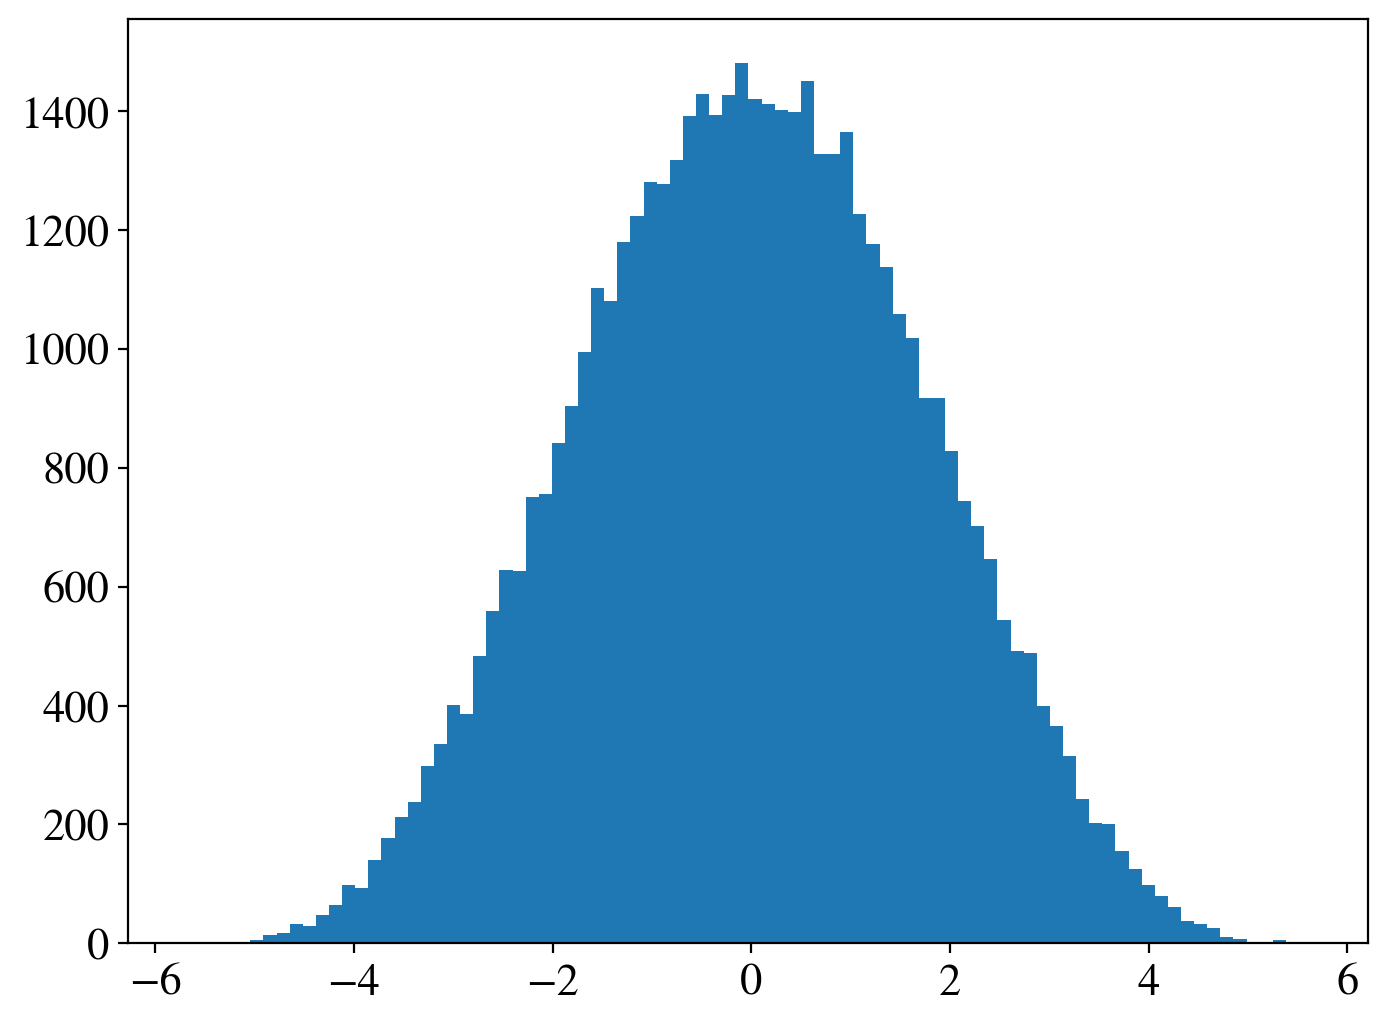

In [ ]:
fig,ax = plt.subplots()

ax.hist(samps[:,10], bins='fd')
#np.save("fisher_sampled_models_50k", samps)

In [ ]:
N=1000
samps = fisher_hypersphere_sampling(fm_modrec, N, radius=6)
np.save("test_data", samps)

1031 points within hypersphere
